## Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import copy
import random

## Загрузка данных

### Задание 1 (0.5 балла)

Для начала работы нам необходимо научиться читать набор данных. В данном домашнем задании мы поработаем с двумя наборами данных.

__covid.csv__ ([источник](https://www.kaggle.com/gpreda/covid-world-vaccination-progress)) - статистика по вакцинированию от COVID19 по разным странам. Для данного датасета нет конкретной предсказательной переменной.

__hr.csv__ ([источник](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)) - набор данных большего размера. Он содержит статистику по людям, проходящим курсы по Big Data & ML. _Target_ - 1 или 0, сменил ли человек работу после прохождения курсов - или нет.

Реализуйте методы `read_covid_dataset` и `read_hr_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. В случае _covid_ датасета `y` возвращается как `None`. 

In [2]:
def read_covid_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    covid_csv = pd.read_csv(path_to_csv)
    X = covid_csv.values
    y = None
    return X, y


def read_hr_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    hr_csv = pd.read_csv(path_to_csv)
    X = hr_csv.values[:, :-1]
    y = hr_csv.values[:, -1]
    return X, y

In [3]:
COVID_DATA_PATH = "./hw1_data/covid.csv"
HR_DATA_PATH = "./hw1_data/hr.csv"

In [4]:
X_covid, _ = read_covid_dataset(COVID_DATA_PATH)
X_hr, y_hr = read_hr_dataset(HR_DATA_PATH)

## EDA

### Задание 2 (3.5 балла)

Выполните задание для датасетa _hr_.

Для дальнейшей работы с данными нужно обработать пропущенные значения в датасете.
Существуют различные стратегии обработки пропущенных данных.

#### 1.  (0.5 балла)

Для числовых признаков постройте распределения признаков. Для категориальных признаков выведите статистику по количеству значений признака.

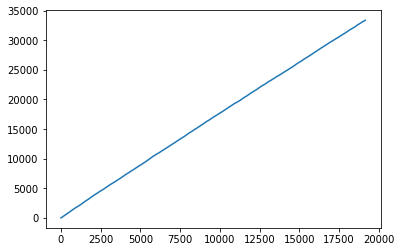

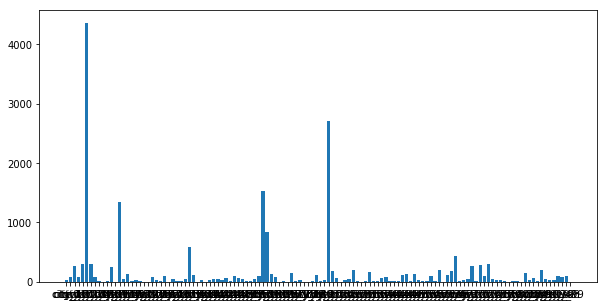

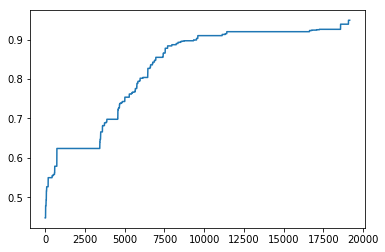

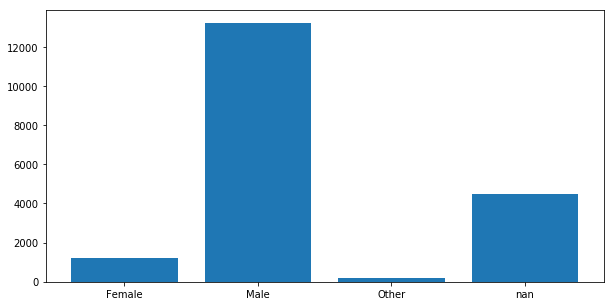

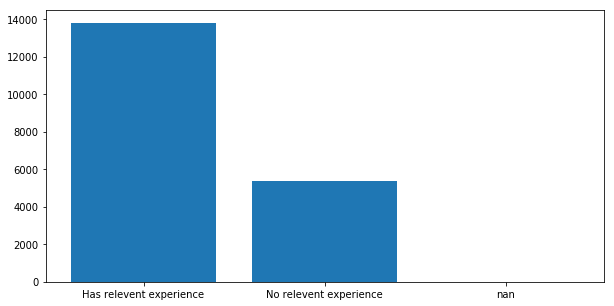

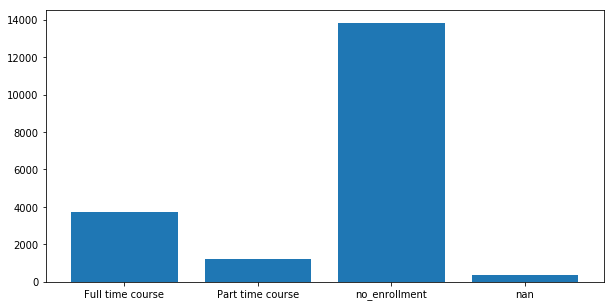

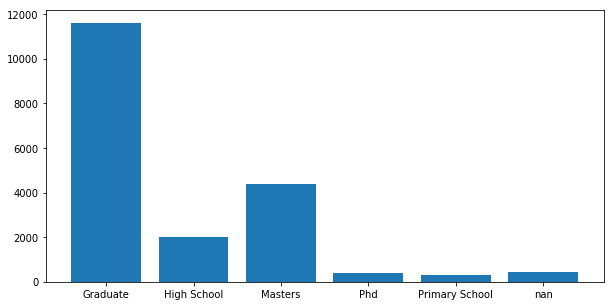

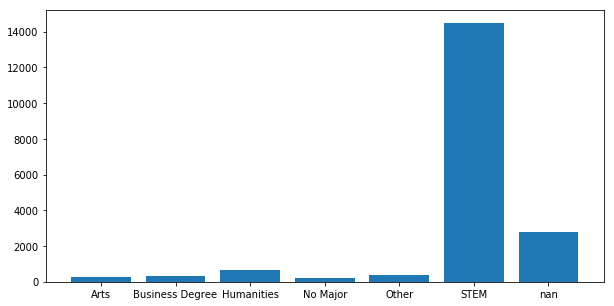

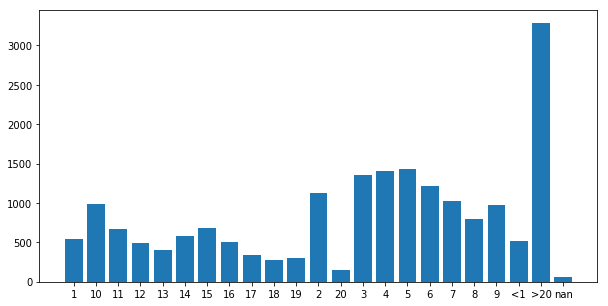

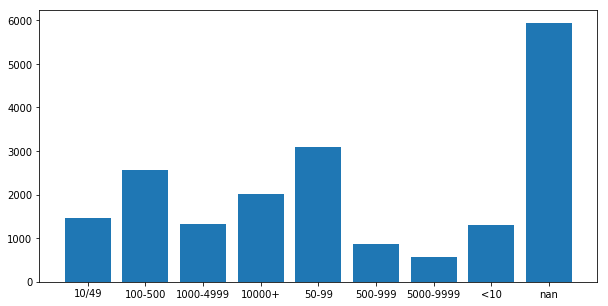

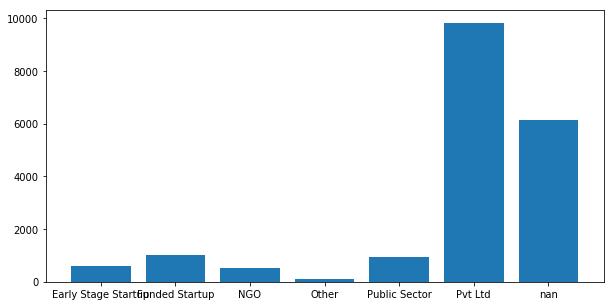

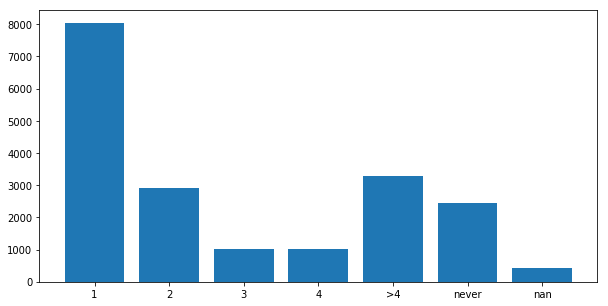

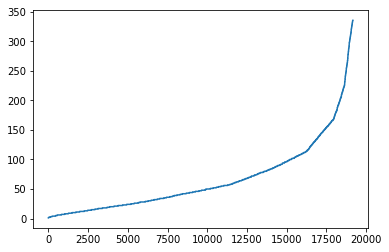

In [5]:
NUM_TYPE = (int,
           float,
           )

# print(X_hr[1, :]) # => 1_st is full (no None)

for i in range(len(X_hr[0])):
    data = []
    for elem in X_hr[:, i]:
        if elem == elem:
            data.append(elem)

    data.sort()
    nan_cnt = len(X_hr[:, i]) - len(data)
    
    if type(X_hr[1][i]) in NUM_TYPE:
        plt.plot(data)
        plt.show()
    else:
        data_cnt = [1]
        for j in range(1, len(data)):
            if data[j] == data[j - 1]:
                data_cnt[-1] += 1
            else:
                data_cnt.append(1)
        
        flags = np.unique((data)).tolist()
        flags.append("nan")
        data_cnt.append(nan_cnt)
        
        
        data = np.array(data)
        data_cnt = np.array(data_cnt)
        flags = np.array(flags)
        
        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(10)
        plt.bar(flags, data_cnt)
        plt.show()


#### 2.  (0.5 балла)
Удалите все строки, где есть хотя бы одно пропущенное значение признака. Насколько сильно уменьшился размер датасета? Как изменились распределения признаков/статистика по количеству значений признаков?

In [6]:
print(f'Исходный размер датасета hr {len(X_hr)}')

Исходный размер датасета hr 19158


In [7]:
X_hr_dropna = []

for line in X_hr:
    no_nan = True
    for elem in line:
        if elem != elem:
            no_nan = False
    if no_nan:
        X_hr_dropna.append(line.tolist())

X_hr_dropna = np.array(X_hr_dropna)

In [8]:
print(f'Pазмер датасета covid без NaN {len(X_hr_dropna)}')

Pазмер датасета covid без NaN 8955


_Ответ:_ Размер датасета уменьшился больше чем в два раза, на 53%

Давайте попробуем избежать сокращения размера датасета.

#### 3.  (1 балл)
Для числовых признаков заполните пропущенные данные средним/медианой/модой данного признака. Объясните свой выбор. (Часть строк с NaN значениями можно удалить, если размер датасета уменьшится <15%)

Нарисуем три графика числовых значений отдельно.

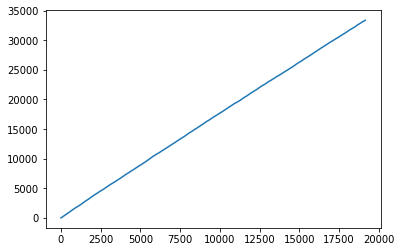

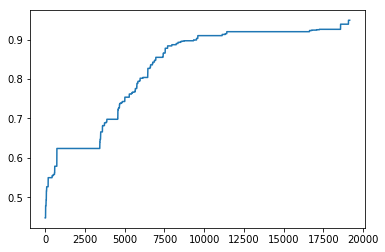

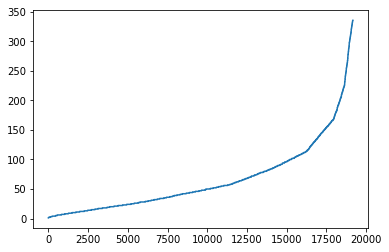

In [9]:
for i in range(len(X_hr[0])):
    if type(X_hr[1][i]) in NUM_TYPE:
        plt.plot(sorted(X_hr[:, i]))
        plt.show()

Представленные числовые признаки имеют очень большой разброс и распределены достаточно непрерывно. Поэтому мы не будем использовать моду для оценку этих признаков. Для первого признака среднее и медиана совпадают. Два других графика являются выпусклыми и отдалённо напоминают гиперболу. Там очень маленькая производная на одном конце и большая на другом. И от этого каждый результат эксперимента на конце очень сильно влиет. Чтобы нивелировать этот эффект возьмём медиану.

#### 4.  (1 балл)
Для категориальных признаков заполните пропущенные значения самой встречающейся категорией или создайте отдельную категорию пропущенных значений. Объясните свой выбор. (Часть строк с NaN значениями можно удалить, если размер датасета уменьшится <15%)

Я предлагаю использовать моду, если пропущенных значений не слишком много. Формализуем меру "много", например, так:

$$\text{Много, если } \%_{nan} > \dfrac{100\%}{\text{количество категорий}}$$

In [10]:
def fill_na(X, y):
    X_fill = copy.copy(X)
    y_fill = copy.copy(y)
    
    for line in range(len(X[0])): # features
        sorted_X = []
        for elem in X[:, line]:
            if elem == elem:
                sorted_X.append(elem)
              
        if type(X[1][line]) in NUM_TYPE: #case of numeric data
            #find median
            fill_with = sorted_X[len(sorted_X) // 2]
            
        else:                            #case of non-numeric data
            data_cnt = [1]
            max_cnt = 1
            most_popular = sorted_X[0]
            #find mode and numbers of Nones
            for j in range(1, len(sorted_X)):
                if sorted_X[j] == sorted_X[j - 1]:
                    data_cnt[-1] += 1
                else:
                    data_cnt.append(1)
                if data_cnt[-1] > max_cnt:
                    max_cnt = data_cnt[-1]
                    most_popular = sorted_X[j]
            
            nan_cnt = len(X[:, line]) - len(sorted_X)
            fill_with = 0
            if (nan_cnt / len(X)) > (1 / len(data_cnt)):
                fill_with = np.nan
            else:
                fill_with = most_popular
        
        #fill X_fill
        for pers in range(len(X)):
            if X[pers][line] == X[pers][line]:
                X_fill[pers][line] = X[pers][line]
            else:
                X_fill[pers][line] = fill_with
    
    return X_fill, y_fill

In [11]:
X_hr_fill, y_hr_fill = fill_na(X_hr, y_hr)

#### 5.  (0.5 балла)
Как изменились распределения признаков/статистика по количеству значений признаков после заполнения пропущенных данных?

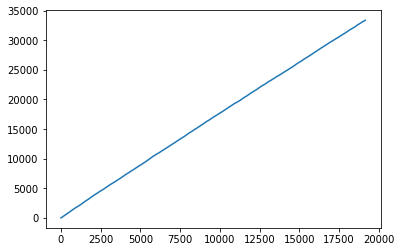

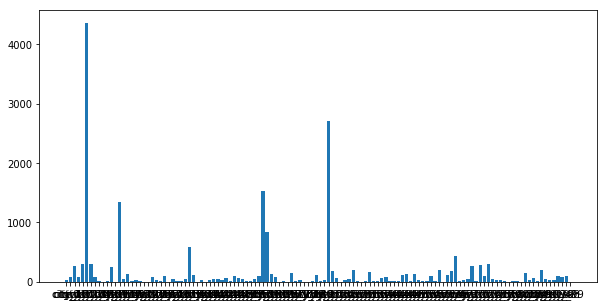

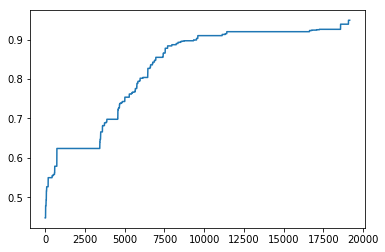

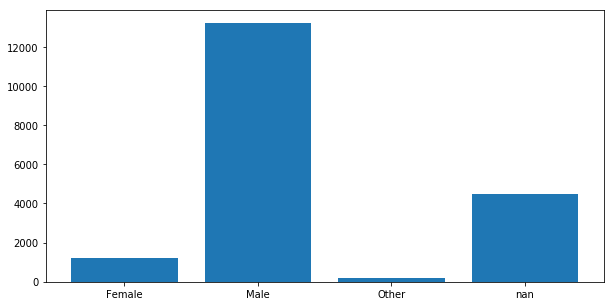

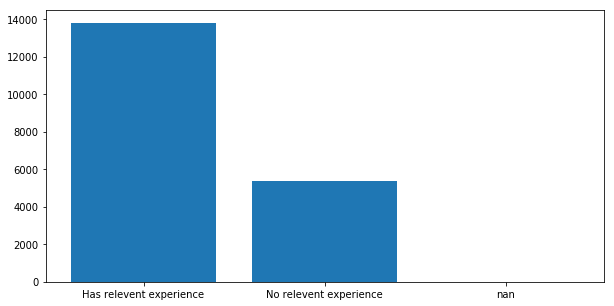

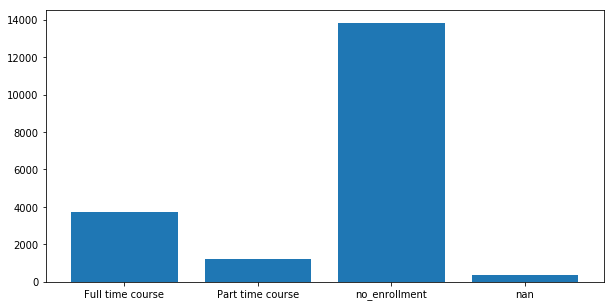

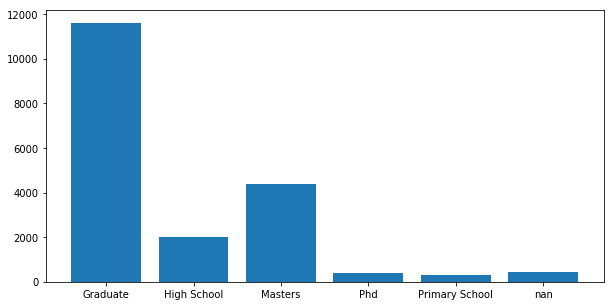

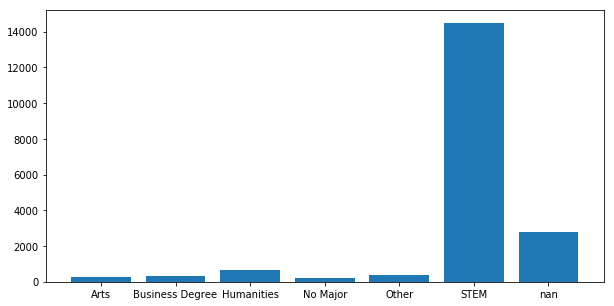

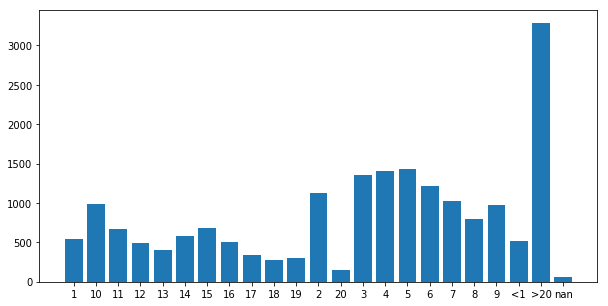

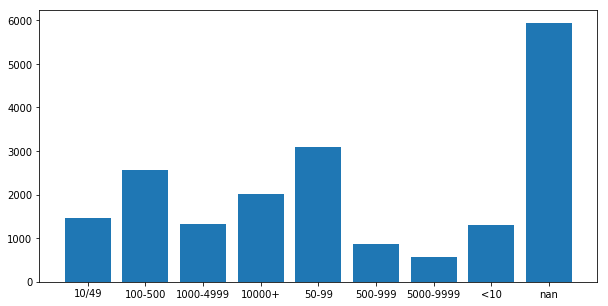

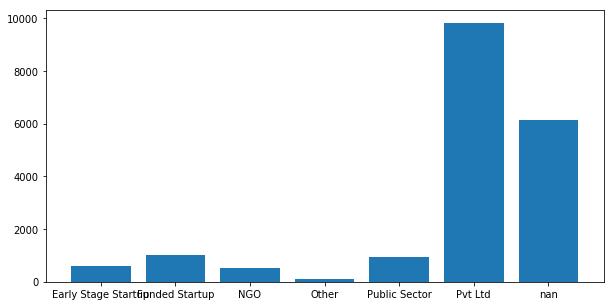

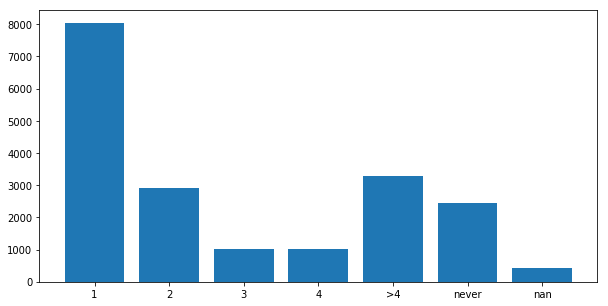

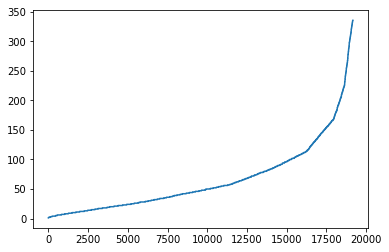

In [12]:
for i in range(len(X_hr_fill[0])):
    if type(X_hr_fill[1][i]) in NUM_TYPE:
        plt.plot(sorted(X_hr_fill[:, i]))
        plt.show()
    else:
        data = []
        for elem in X_hr_fill[:, i]:
            if elem == elem:
                data.append(elem)
        
        data.sort()
        data_cnt = [1]
        for j in range(1, len(data)):
            if data[j] == data[j - 1]:
                data_cnt[-1] += 1
            else:
                data_cnt.append(1)
                
        nan_cnt = len(X_hr_fill[:, i]) - len(data)
        
        flags = np.unique((data)).tolist()
        flags.append("nan")
        data_cnt.append(nan_cnt)
        
        
        data = np.array(data)
        data_cnt = np.array(data_cnt)
        flags = np.array(flags)
        
        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(10)
        plt.bar(flags, data_cnt)
        plt.show()

_Ответ:_ Числовые графики не изменились (как я посмотрел, там нет пропущенных значений...), некоторыеграфики с категориями немного поменялись в пользу увеличения самого популярного варианта

### Задание 3 (1 балл)

Выполните задание для датасета _covid_.

1. Найдите страну, для которой в датасете присутствует 46 дат со статистикой по вакцинации.
2. Постройте для этой страны график зависимости _total_vaccinations_ от _date_.
3. Заполните пропущенные данные о _total_vaccinations_ для этой страны. Объясните свой выбор.

In [13]:
#   1   #
first_col = sorted(X_covid[:, 0])
countries = np.unique(np.array(first_col)).tolist()
for country in countries:
    if first_col.count(country) == 46:
        print(country)

Bahrain


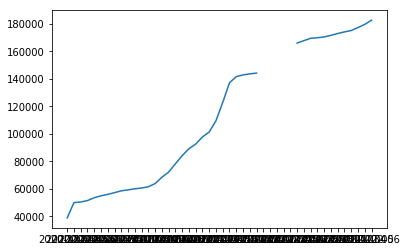

['2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06']
[38965.0, 50071.0, 50543.0, 51556.0, 53614.0, 55014.0, 56041.0, 57317.0, 58643.0, 59351.0, 60097.0, 60689.0, 61612.0, 63893.0, 68472.0, 72239.0, 78291.0, 84157.0, 89250.0, 92598.0, 97776.0, 101363.0, 109566.0, 122819.0, 137159.0, 141563.0, 142831.0, 143596.0, 144130.0, nan, nan, nan, nan, nan, 165953.0, 167731.0, 169440.0, 169810.0, 170433.0, 171568.0, 

In [14]:
#   2   #

# data               - 3rd colomn
# total_vaccinations - 4th colomn

x_axis, y_axis = [], []
for line in X_covid:
    if line[0] == 'Bahrain':
        x_axis.append(line[2])
        y_axis.append(line[3])
plt.plot(x_axis, y_axis)
plt.show()

print(x_axis)
print(y_axis)

2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-25


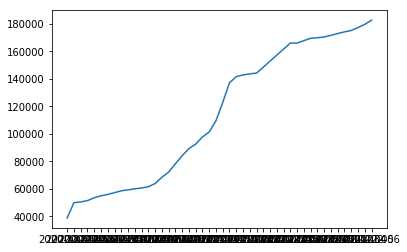

In [15]:
#   3   #

diff = (165953.0 - 144130.0) / 5
for i in range(len(y_axis)):
    if y_axis[i] != y_axis[i]:
        print(x_axis[i])
        y_axis[i] = y_axis[i - 1] + diff
plt.plot(x_axis, y_axis)
plt.show()

Нам точно известно, что эта функция монотонно неубывает. Более того, результаты исследования проводились каждый день. То есть у нас нет оснований предполагать в какой из промежутков было вакцинировано больше людей. Поэтому я выбрал аппроксимацию линейной функцией

### Задание 4  (0.5 балла)
Выполните задание для датасета _hr_.

Есть ли в данных выбросы? Если да, то скажите, какие и почему Вы считаете их выбросами?


In [16]:
# YOUR_CODE

_Ваш ответ_ Единственный существенный выброс, который я заметил -- ответ "primary school" в графе "edu level".
Ещё можно заметить, что люди сколонны округлять, оценивания свой стаж. Таким образом, числа 5, 10 и 15 являются локальными (но очень небольшими). Остальные данные выглядят правдоподобными

### Задание 5  (1 балл)
Выполните задание для датасета _hr_.

Закодируйте категориальные признаки при помощи One-hot encoding/Label encoding/Frequency encoding. Объясните свой выбор. (Обратите внимание, что некоторые категориальные признаки предполагают ранжирование в своих значениях)


In [17]:
def encode(X):
    X_encode = X[:,0]
    X_encode = X_encode.reshape(-1, 1)
    for i in range(1, len(X[0])):
        if type(X[1][i]) in NUM_TYPE:
            X_encode = np.insert(X_encode, len(X_encode[0]), X[:, i], axis=1)
        else:
            data = []
            for elem in X[:, i]:
                if elem == elem:
                    data.append(elem)

            flags = np.unique((data)).tolist()
            for flag in flags:
                to_insert = []
                for elem in X[:, i]:
                    if elem == flag:
                        to_insert.append(1)
                    else:
                        to_insert.append(0)
                
                X_encode = np.insert(X_encode, len(X_encode[0]), to_insert, axis=1)
    return X_encode

In [18]:
X_hr_encode = encode(X_hr_fill)

_Ваш ответ_ Долго думая, я решил остановиться на One-hot encoding для всех категориальных признаков. Не обладая знаниями в области HR и рекрутинга, мне сложно судить как определённый бэкграунд влияет на вероятность того, сменит человек работу или нет. В качетсве обоснования привожу краткие рассуждения про каждый категориальный признак

City code -- не зная городов тут сложно делать Label encoding. А для Frequency encoding неизвестно хорошо быть в городе где много таких же (например, они сейчас соберутся и откроют новую комапанию) или мало (меньше конкуренция)

Gender M/F -- можно было бы использовать факт, что сейчас в IT меньше женщин, но для того, чтобы сказать, повлияет ли это на их желание сменить работу, нужно мнение экспертов

Relevent experience, Type of university of the enrolee, major_discipline -- с одной стороны, если у человека уже есть опыт, возможно ему проще найти новое место для применения своих знаний, с другой стороны, если он новичок в этой области, возможно, это сильнее повлияет на его смену работы

Total experience in years, edu level -- с одной стороны если человек молодой, то у него больше вариантивность и меньше страха менять работу, с другой стороны если у человека много стажа и он проходит этот курс, вероятно, он хочет сменить работу

No of employees in current employer's company -- вероятно, в компаниях с меньшим числом людей меньше "текучка", но с другой стороны они чаще разваливаются (что влияет на необходимость искать новую работу)

### Задание 6 (3.5 балла)

Выполните задание для датасета _hr_.




#### 1. (1 балл)
Реализуйте функцию undersampling

#### 2. (1 балл)
Реализуйте функцию oversampling

In [19]:
def undersampling(X, y):
    X_0_ind = []
    X_1_ind = []
    for i in range(len(y)):
        if y[i] == 0:
            X_0_ind.append(i)
        else:
            X_1_ind.append(i)
    
    total_indexes = copy.copy(X_1_ind) # add all          of X_1_ind
    for i in range(len(X_1_ind)):      # add len(X_1_ind) of X_0_ind
        total_indexes.append(random.choice(X_0_ind))
    
    X_under = X[total_indexes]
    y_under = [1.0] * len(X_0_ind) + [0.0] * len(X_0_ind)
    return X_under, y_under

def oversampling(X, y):
    # Возвращает данные, сбалансированные методом overrsampling
    X_0_ind = []
    X_1_ind = []
    for i in range(len(y)):
        if y[i] == 0:
            X_0_ind.append(i)
        else:
            X_1_ind.append(i)
    
    total_indexes = copy.copy(X_0_ind) # add all          of X_0_ind
    for i in range(len(X_0_ind)):      # add len(X_0_ind) of X_1_ind
        total_indexes.append(random.choice(X_1_ind))
    
    X_over = X[total_indexes]
    y_over = [0.0] * len(X_0_ind) + [1.0] * len(X_0_ind)
    
    return X_over, y_over

In [20]:
X_hr_under, y_hr_under = undersampling(X_hr_encode, y_hr_fill)

X_hr_over, y_hr_over = oversampling(X_hr_encode, y_hr_fill)

#### 3. (1 балл)
Используйте _SMOTE_ для балансировки датасета.

Помимо методов _undersampling_ и _oversampling_ существует подход, генерирующий элементы класса-меньшинства, похожие на уже присутствующие в выборке данных. Такой метод называется _Synthetic Minority Oversampling Technique_ (SMOTE). 

Метод _SMOTE_ , реализованный в библиотеке `imblearn`, генерирует синтетические примеры при помощи __k-nearest neighbor__ алгоритма (подробнее об этом алгоритме будет рассказано на лекции).

In [22]:
!pip install -U imbalanced-learn --user

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [21]:
from imblearn.over_sampling import SMOTE


print("Before OverSampling, counts of label '1': {}".format(sum(y_hr_fill==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_hr_fill==0)))

y_hr_fill=y_hr_fill.astype('int')
sm = SMOTE()
X_hr_SMOTE, y_hr_SMOTE = sm.fit_sample(X_hr_encode, y_hr_fill.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_hr_SMOTE.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_hr_SMOTE.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_hr_SMOTE==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_hr_SMOTE==0)))

Before OverSampling, counts of label '1': 4777
Before OverSampling, counts of label '0': 14381 

After OverSampling, the shape of train_X: (28762, 187)
After OverSampling, the shape of train_y: (28762,) 

After OverSampling, counts of label '1': 14381
After OverSampling, counts of label '0': 14381


#### 4. (0.5 балла)
Как изменились распределения признаков при различных тактиках балансирования датасета?

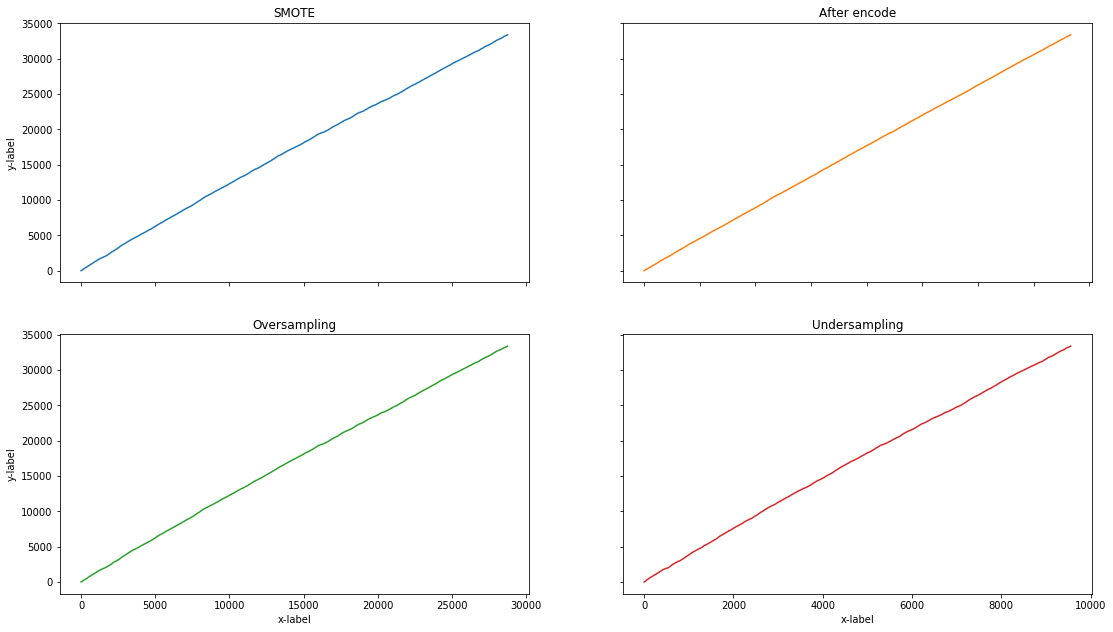

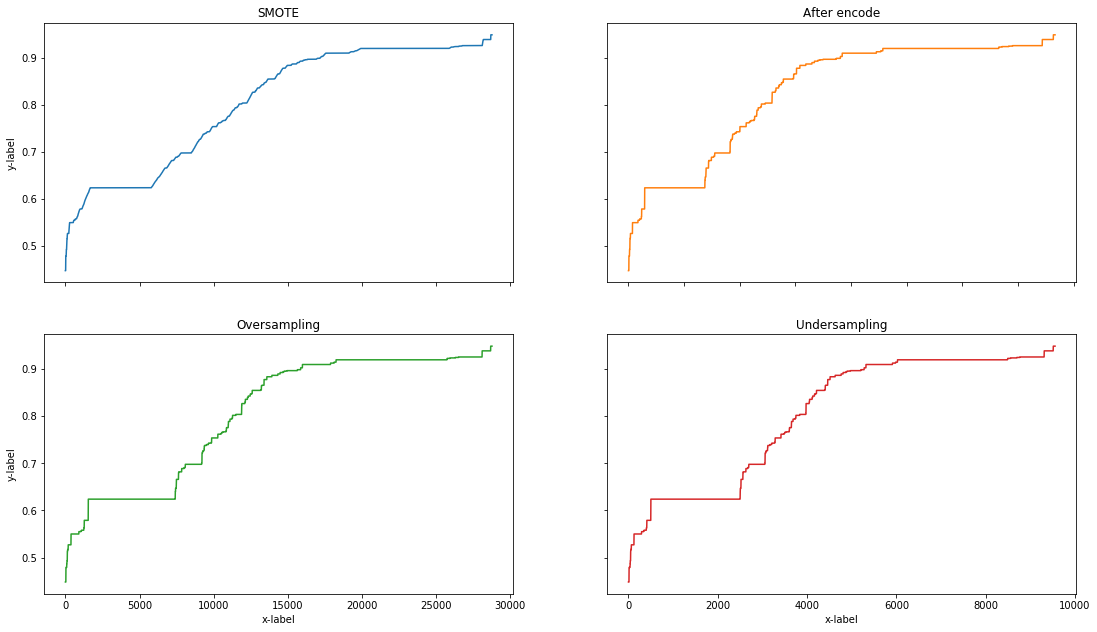

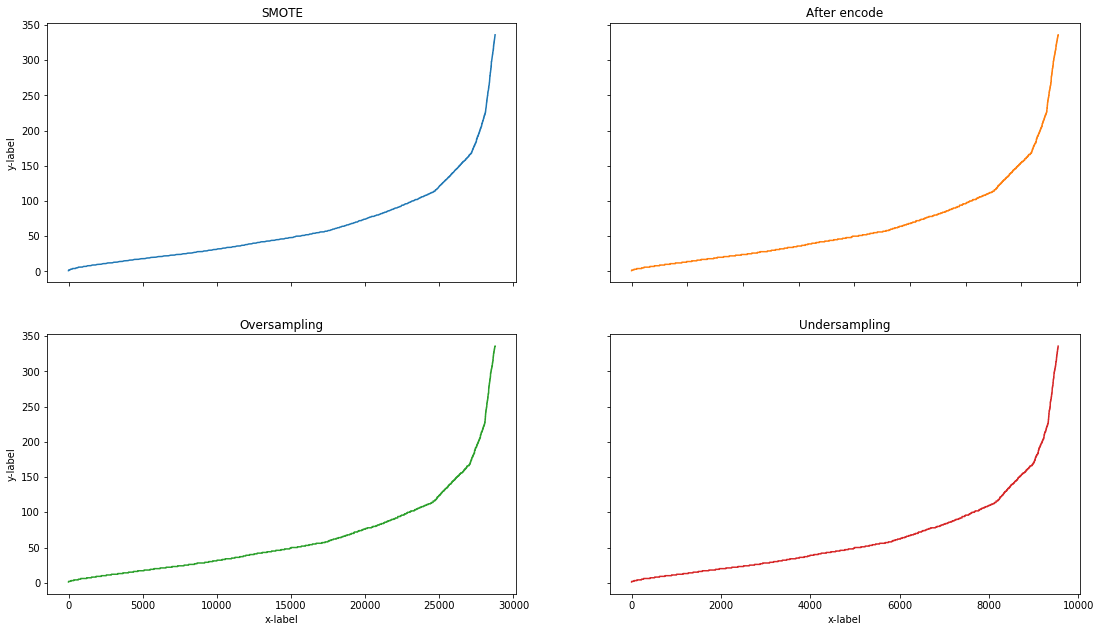

In [25]:
for i in [0, 124, 186]:
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(18.5, 10.5)
    axs[0, 1].plot(sorted(X_hr_encode[:, i]), 'tab:orange')
    axs[0, 1].set_title('After encode')
    axs[0, 0].plot(sorted(X_hr_SMOTE[:, i]))
    axs[0, 0].set_title('SMOTE')
    axs[1, 0].plot(sorted(X_hr_over[:, i]), 'tab:green')
    axs[1, 0].set_title('Oversampling')
    axs[1, 1].plot(sorted(X_hr_under[:, i]), 'tab:red')
    axs[1, 1].set_title('Undersampling')

    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

_Ответ_ Посмотрев только на числовые признаки уже видно, что в целом Oversampling и Undersampling дают что-то очень похожее на то, что было. Но SMOTE приближает лучше всего

Впрочем, из этого сложно сделать вывод о том, какой из методов лучше. Ведь мы хотим сделать так, чтобы они были более диффеернцируемы в зависимости от y. А предаставленные графики только говорят о том, что по выбранным категориям нельзя ничего сказать о том изменится место работы изучаемого человека или нет